In [44]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

## Loading data

In [45]:
train = pd.read_csv("application_train.csv")
test = pd.read_csv("application_test.csv")
prev_application = pd.read_csv("previous_application.csv")
bureau = pd.read_csv("bureau.csv")
bureau_balance = pd.read_csv("bureau_balance.csv")
credit_card_balance = pd.read_csv("credit_card_balance.csv")
installments_payments = pd.read_csv("installments_payments.csv")
POS_CASH_balance = pd.read_csv("POS_CASH_balance.csv")

## Utils

#### 1. Label Encoding

In [46]:
# Encoding of categorical variables with no more than 2 values

def labelEncoding(df):
    le = LabelEncoder()
    for column in df:
        if df[column].dtypes == object and len(df[column].unique()) <= 2:
            le.fit(df[column])
            df[column] = le.transform(df[column])
    return df

In [47]:
# Encoding of categorical variables with more than 2 values

def oneHotEncoding(df):
    return pd.get_dummies(df)

#### 2. Removing missing values

In [48]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [49]:
def missingValuesHandler(df):
    for col in df:
        if col != 'TARGET' and df[col].isna().any() :
            median = df[col].median()
            df[col].fillna(median, inplace=True)
    #imputer = IterativeImputer()
    #imputer.fit(df)
    #imputedDf = pd.DataFrame(imputer.transform(df), columns=df.columns) 
    return df

In [50]:
gc.collect()

33

## Exploratory data analysis

### 1. Unbalanced class problem

The loan was repaid in the percentage of  91.93 %
The loan was not repaid in the percentage of  8.07 %


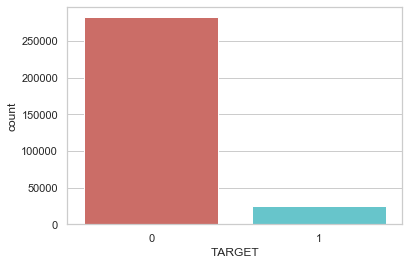

In [51]:
train.TARGET.value_counts()
sns.countplot(x='TARGET', data= train, palette='hls')

count_loan_repaid = len(train[train['TARGET']==0])
count_loan_no_repaid = len(train[train['TARGET']==1])
pct_of_loan_repaid = count_loan_repaid/(count_loan_no_repaid+count_loan_repaid)
print("The loan was repaid in the percentage of ", round(pct_of_loan_repaid*100, 2), '%')
pct_of_loan_no_repaid = count_loan_no_repaid/(count_loan_no_repaid+count_loan_repaid)
print("The loan was not repaid in the percentage of ", round(pct_of_loan_no_repaid*100,2), '%')

The plot above shows the we are delaing with an imbalanced class problem, in particular the ratio of repaid-loans to no-repaid-loan is 92:8.

### 2. Processing of train/test datasets

In [52]:
# Alignement of the columns of the train and test dataset
target = train['TARGET']
train, test = train.align(test, join = 'inner', axis = 1)
train['TARGET'] = target

In [53]:
# Concatenate train and test
trainTest = train.append(test, ignore_index = True)
#trainTest = pd.concat([train, test], ignore_index=True, sort=False)

In [54]:
trainTest.groupby('TARGET').mean()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
TARGET,,,,,,,,,,,,,,,,,,,,,
0.0,278244.744536,0.412946,169077.722266,602648.282002,27163.623349,542736.795003,0.021021,-16138.176397,65696.146123,-5029.941065,...,0.008341,0.000605,0.000506,0.000315,0.006380,0.006914,0.034315,0.270697,0.265939,1.889199
1.0,277449.167936,0.463807,165611.760906,557778.527674,26481.744290,488972.412554,0.019131,-14884.828077,42394.675448,-4487.127009,...,0.005720,0.000483,0.000524,0.000564,0.006672,0.008036,0.034919,0.227926,0.259923,2.028783


### 3. Anomalies in the the train and test datasets

In [55]:
# Substitute the column DAYS_BIRTH with one stating clearly the age of the person
trainTest['AGE'] = trainTest['DAYS_BIRTH']/ -365
trainTest = trainTest.drop('DAYS_BIRTH', axis=1)

In [56]:
trainTest.dtypes.value_counts()

float64    67
int64      39
object     16
dtype: int64

In [57]:
# Keep a list of all the numerical variables, in order to detect and solve eventual anomalies

features = []
for col in trainTest:
    if trainTest[col].dtypes != 'object' and col != 'SK_ID_CURR':
        features.append(col)

len(features)

105

C:\Users\clara.punzi\Miniconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\clara.punzi\Miniconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


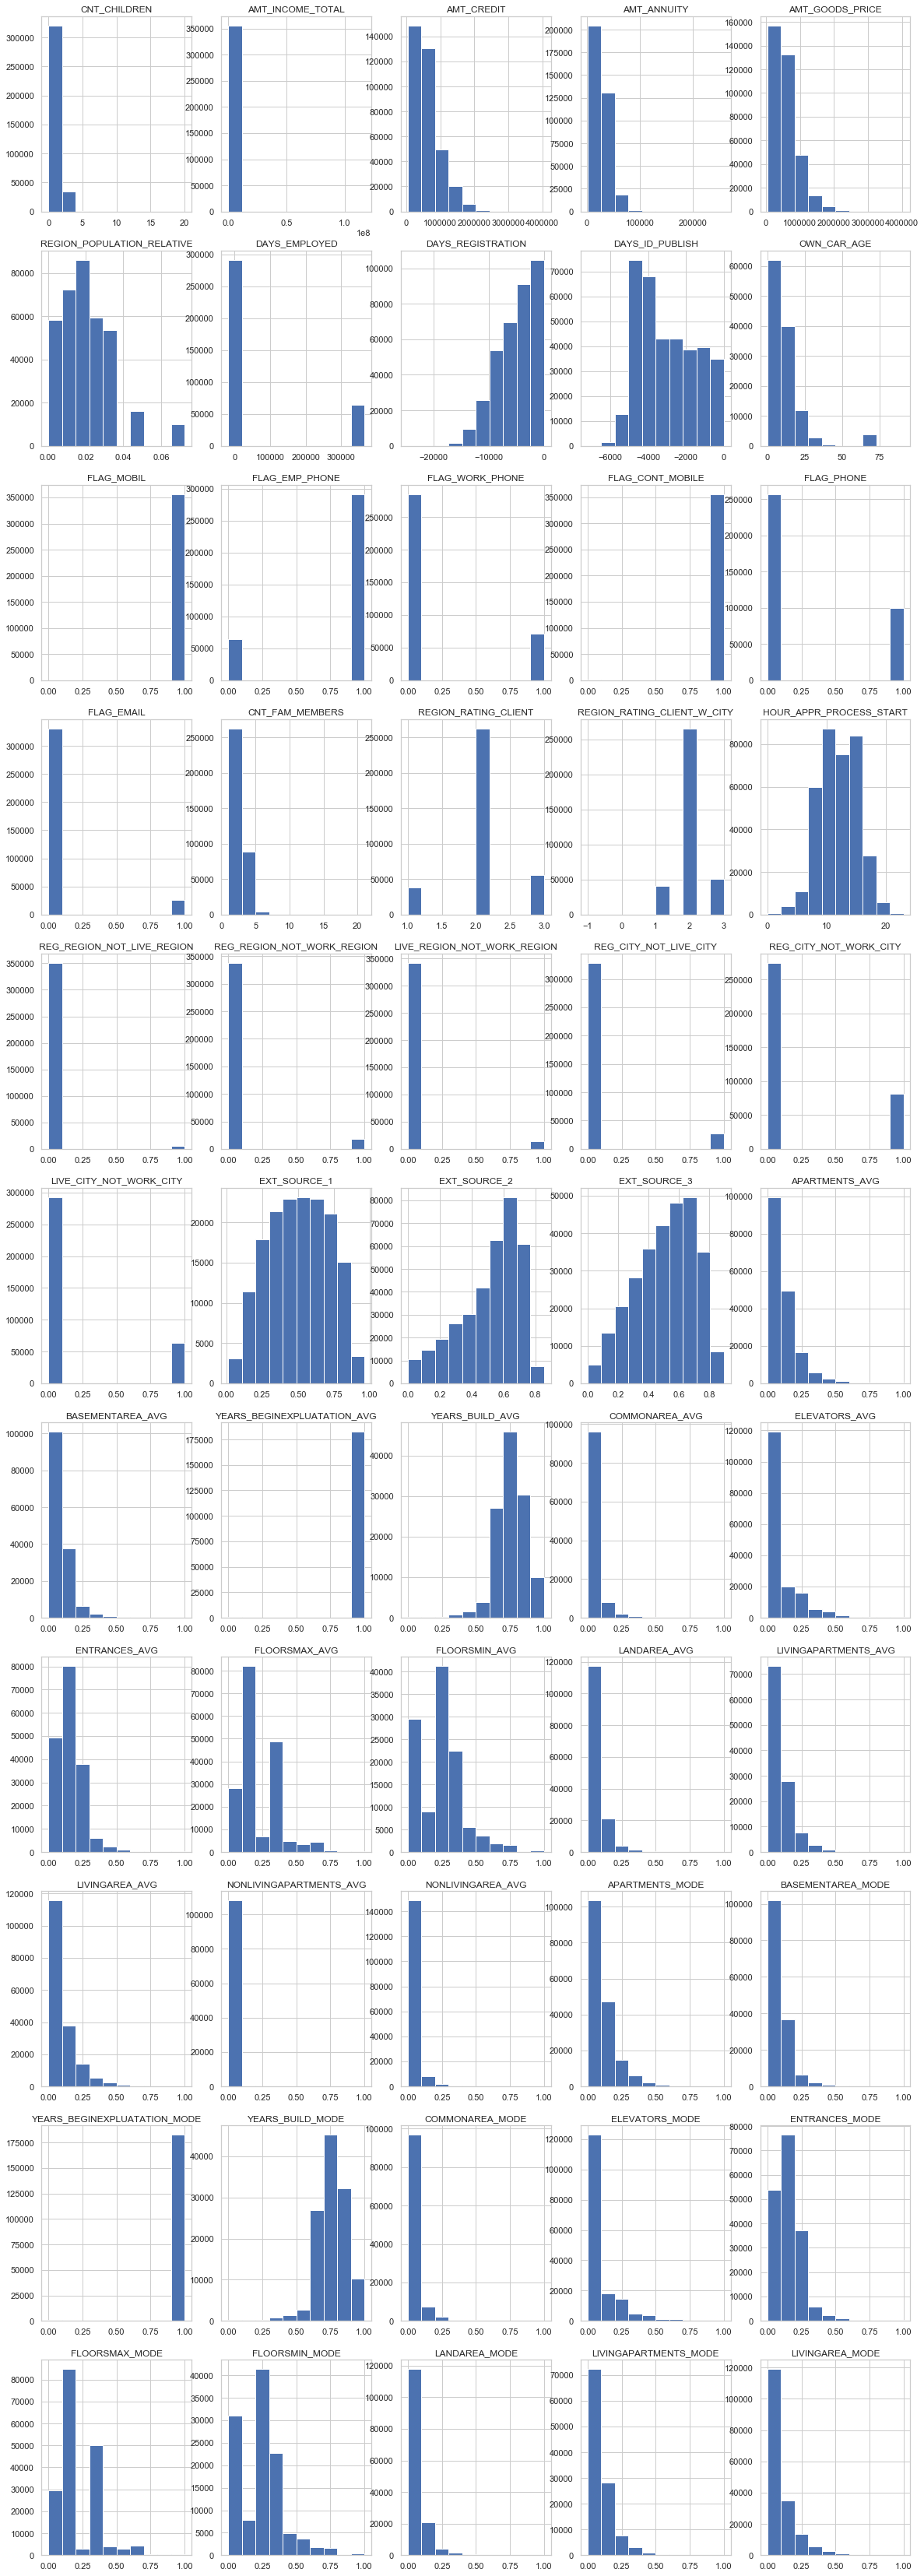

In [58]:
fig, ax = plt.subplots(11, 5, figsize=(20,60))
counter =  0
for i in range(11):
    for j in range(5):
        ax[i, j].hist(trainTest[features[counter]])
        ax[i, j].set_title(features[counter])
        counter +=1

#### 3.1. DAYS_EMPLOYED

In [59]:
trainTest['DAYS_EMPLOYED'].describe()

count    356255.000000
mean      64317.231413
std      141705.532576
min      -17912.000000
25%       -2781.000000
50%       -1224.000000
75%        -290.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [60]:
trainTest['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
# Replace the anomalies with mean value obtained from above
trainTest['DAYS_EMPLOYED'].replace({365243: -2397}, inplace = True)

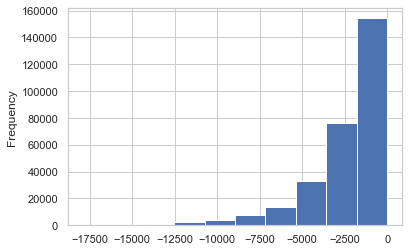

In [61]:
trainTest['DAYS_EMPLOYED'].plot(kind='hist')

#### 3.2. OWN_CAR_AGE 

In [62]:
carAgeMode = trainTest['OWN_CAR_AGE'].mode(dropna=False)
trainTest[trainTest['OWN_CAR_AGE']>40]['OWN_CAR_AGE'].unique()

array([65., 64., 41., 42., 54., 43., 55., 49., 44., 63., 46., 45., 48.,
       56., 51., 57., 69., 50., 47., 91., 52., 74.])

In [63]:
trainTest['OWN_CAR_AGE'] = trainTest['OWN_CAR_AGE'].apply(lambda x: np.where(x > 40,carAgeMode[0],x))

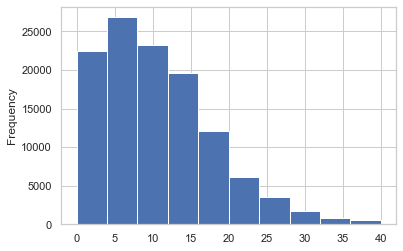

In [64]:
trainTest['OWN_CAR_AGE'].plot(kind='hist')

#### 3.2. REGION_RATING_CLIENT_W_CITY 

This feature can take values only in {1,2,3}

In [65]:
trainTest['REGION_RATING_CLIENT_W_CITY'].describe()

count    356255.000000
mean          2.028932
std           0.504586
min          -1.000000
25%           2.000000
50%           2.000000
75%           2.000000
max           3.000000
Name: REGION_RATING_CLIENT_W_CITY, dtype: float64

In [66]:
trainTest['REGION_RATING_CLIENT_W_CITY'].replace({-1: 1}, inplace = True)

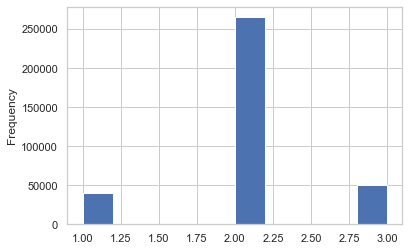

In [67]:
trainTest['REGION_RATING_CLIENT_W_CITY'].plot(kind='hist')

### 4. Anomalies in the other datasets
#### 4.1. PREV_APPLICATION

In [68]:
prev_application.dtypes.value_counts()

object     16
float64    15
int64       6
dtype: int64

In [69]:
# Keep a list of all the numerical variables, in order to detect and solve eventual anomalies
features = []
for col in prev_application:
    if prev_application[col].dtypes != 'object' and col != 'SK_ID_CURR':
        features.append(col)
len(features)

20

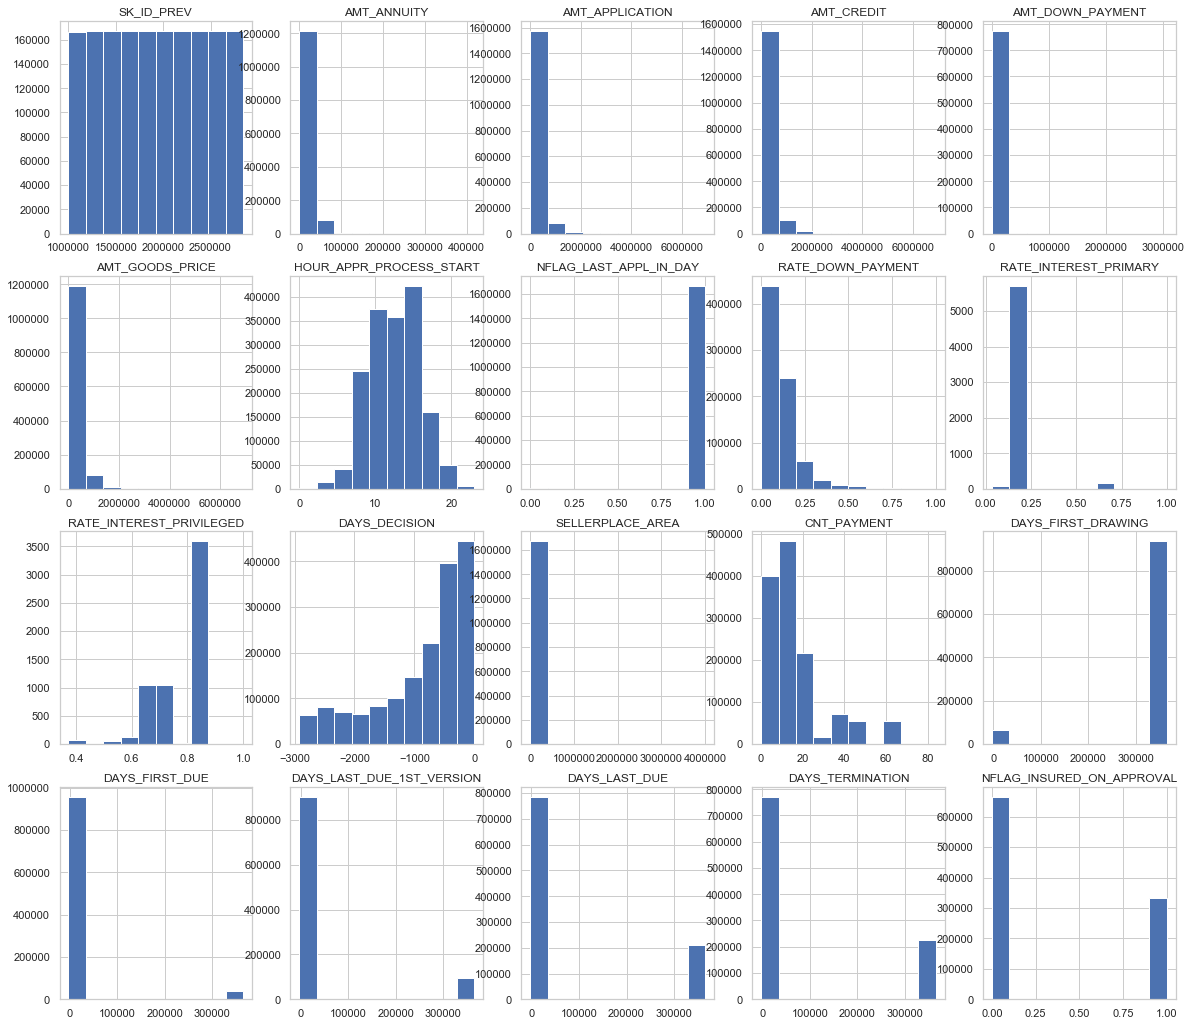

In [70]:
fig, ax = plt.subplots(4, 5, figsize=(20,18))
counter =  0
for i in range(4):
    for j in range(5):
        ax[i, j].hist(prev_application[features[counter]])
        ax[i, j].set_title(features[counter])
        counter +=1

In [71]:
featuresWithAnomalies = ['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']

In [72]:
# Replace the anomalies with the mean value of the correct available data
for feat in featuresWithAnomalies:
    prev_application[feat].replace({365243: np.nan}, inplace = True)
    meanValue = prev_application[feat].mean()
    prev_application[feat].replace({365243: meanValue}, inplace = True)

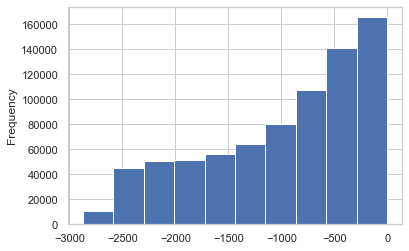

In [73]:
prev_application['DAYS_TERMINATION'].plot(kind='hist')

#### 4.2. POS_CASH_balance

In [74]:
POS_CASH_balance.dtypes.value_counts()

int64      5
float64    2
object     1
dtype: int64

In [75]:
# Keep a list of all the numerical variables, in order to detect and solve eventual anomalies
featuresPOS = []
for col in POS_CASH_balance:
    if POS_CASH_balance[col].dtypes != 'object' and col != 'SK_ID_CURR' and col != 'SK_ID_PREV':
        featuresPOS.append(col)
len(featuresPOS)

5

Text(0.5, 1.0, 'SK_DPD_DEF')

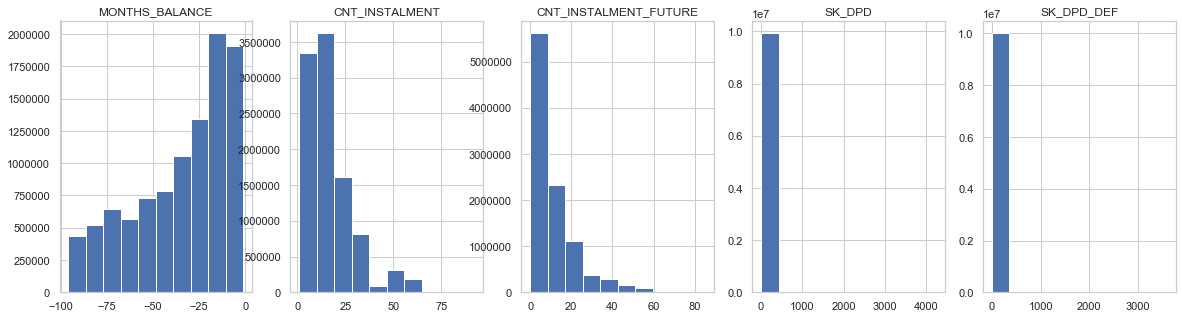

In [76]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (20,5))
ax1.hist(POS_CASH_balance[featuresPOS[0]])
ax1.set_title(featuresPOS[0])
ax2.hist(POS_CASH_balance[featuresPOS[1]])
ax2.set_title(featuresPOS[1])
ax3.hist(POS_CASH_balance[featuresPOS[2]])
ax3.set_title(featuresPOS[2])
ax4.hist(POS_CASH_balance[featuresPOS[3]])
ax4.set_title(featuresPOS[3])
ax5.hist(POS_CASH_balance[featuresPOS[4]])
ax5.set_title(featuresPOS[4])

#### 4.3. INSTALLMENT_PAYMENTS

In [77]:
installments_payments.dtypes.value_counts()

float64    5
int64      3
dtype: int64

In [78]:
# Keep a list of all the numerical variables, in order to detect and solve eventual anomalies
featuresINST = []
for col in installments_payments:
    if col != 'SK_ID_CURR' and col != 'SK_ID_PREV':
        featuresINST.append(col)
len(featuresINST)

6

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B6033869C8>,
      dtype=object)

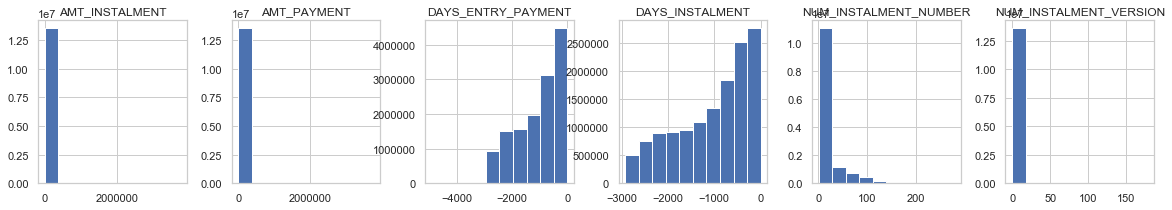

In [79]:
installments_payments[featuresINST].hist(layout=(1,6), figsize=(20,3))

#### 4.4. CREDIT_CARD_BALANCE

In [80]:
credit_card_balance.dtypes.value_counts()

float64    15
int64       7
object      1
dtype: int64

In [81]:
# Keep a list of all the numerical variables, in order to detect and solve eventual anomalies
featuresCC = []
for col in credit_card_balance:
    if credit_card_balance[col].dtypes != 'object' and col != 'SK_ID_CURR' and col != 'SK_ID_PREV':
        featuresCC.append(col)
len(featuresCC)

20

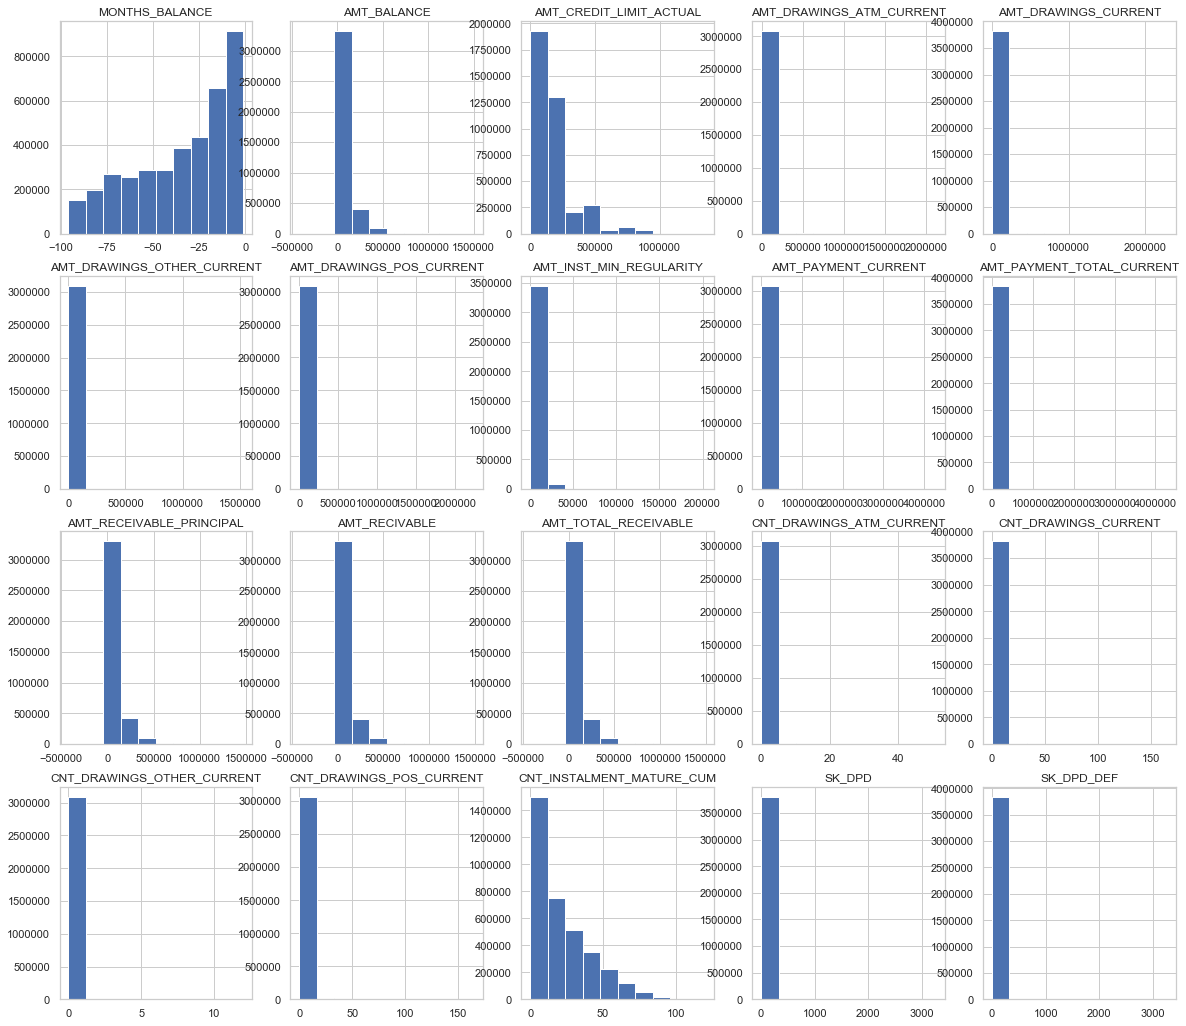

In [82]:
fig, ax = plt.subplots(4, 5, figsize=(20,18))
counter =  0
for i in range(4):
    for j in range(5):
        ax[i, j].hist(credit_card_balance[featuresCC[counter]])
        ax[i, j].set_title(featuresCC[counter])
        counter +=1

In [83]:
credit_card_balance['AMT_DRAWINGS_ATM_CURRENT'].describe()

count    3.090496e+06
mean     5.961325e+03
std      2.822569e+04
min     -6.827310e+03
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.115000e+06
Name: AMT_DRAWINGS_ATM_CURRENT, dtype: float64

#### 4.5 BUREAU

In [84]:
bureau.dtypes.value_counts()

float64    8
int64      6
object     3
dtype: int64

In [85]:
featuresB = []
for col in bureau:
    if bureau[col].dtypes != 'object' and col != 'SK_ID_CURR' and col != 'SK_ID_BUREAU':
        featuresB.append(col)
len(featuresB)

12

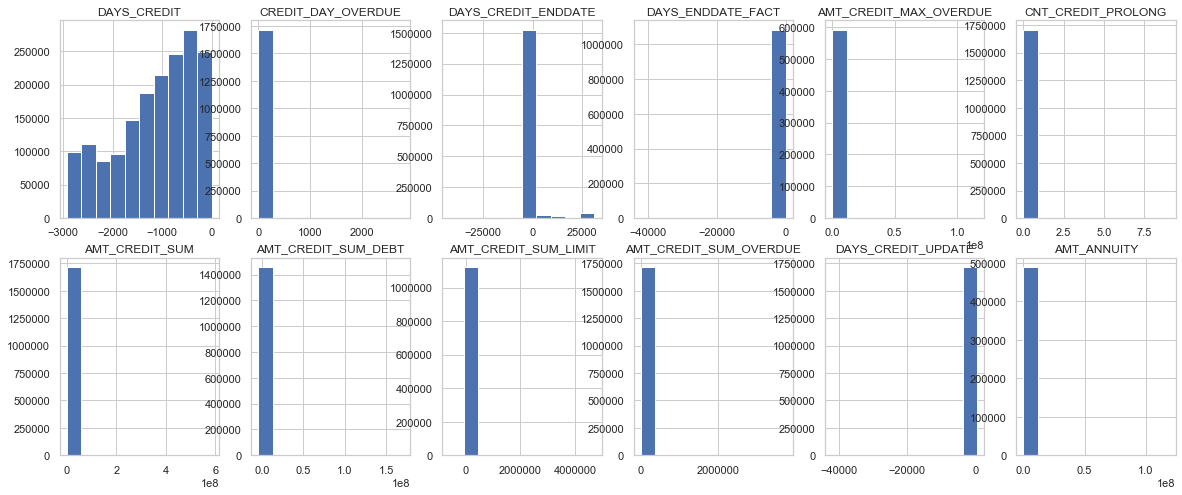

In [86]:
fig, ax = plt.subplots(2, 6, figsize=(20,8))
counter =  0
for i in range(2):
    for j in range(6):
        ax[i, j].hist(bureau[featuresB[counter]])
        ax[i, j].set_title(featuresB[counter])
        counter +=1

### 5. Encoding categorical variables and removing missing values

In [87]:
import gc
gc.collect()

55401

#### 5.1 TrainTest

In [88]:
trainTest.dtypes.value_counts()

float64    68
int64      38
object     16
dtype: int64

In [89]:
trainTest = labelEncoding(trainTest)
trainTest.dtypes.value_counts()

float64    68
int64      38
object     13
int32       3
dtype: int64

In [90]:
trainTest = oneHotEncoding(bureau)
trainTest.dtypes.value_counts()

uint8      23
float64     8
int64       6
dtype: int64

In [91]:
trainTest = missingValuesHandler(trainTest)
trainTest.isnull().values.any()

False

#### 5.2 Prev_application

In [92]:
prev_application.dtypes.value_counts()

object     16
float64    15
int64       6
dtype: int64

In [93]:
prev_application = labelEncoding(prev_application)
prev_application.dtypes.value_counts()

object     15
float64    15
int64       6
int32       1
dtype: int64

In [94]:
prev_application = oneHotEncoding(prev_application)
prev_application.dtypes.value_counts()

uint8      141
float64     15
int64        6
int32        1
dtype: int64

In [95]:
prev_application = missingValuesHandler(prev_application)
prev_application.isnull().values.any()

False

#### 5.3 Bureau

In [96]:
bureau = oneHotEncoding(bureau)
bureau.dtypes.value_counts()

uint8      23
float64     8
int64       6
dtype: int64

In [97]:
bureau = missingValuesHandler(bureau)
bureau.isnull().values.any()

False

In [98]:
gc.collect()

99

#### 5.4 Bureau_balance

In [99]:
bureau_balance = oneHotEncoding(bureau_balance)
bureau_balance.dtypes.value_counts()

uint8    8
int64    2
dtype: int64

In [100]:
bureau_balance = missingValuesHandler(bureau_balance)
bureau_balance.isnull().values.any()

False

#### 5.5 Credit_card_balance

In [101]:
credit_card_balance = oneHotEncoding(credit_card_balance)
credit_card_balance.dtypes.value_counts()

float64    15
uint8       7
int64       7
dtype: int64

In [102]:
credit_card_balance = missingValuesHandler(credit_card_balance)
credit_card_balance.isnull().values.any()

False

#### 5.6 Installments_payments

In [103]:
installments_payments = oneHotEncoding(installments_payments)
installments_payments.dtypes.value_counts()

float64    5
int64      3
dtype: int64

In [104]:
installments_payments = missingValuesHandler(installments_payments)
installments_payments.isnull().values.any()

False

#### 5.7 POS_CASH_balance

In [105]:
POS_CASH_balance = oneHotEncoding(POS_CASH_balance)
POS_CASH_balance.dtypes.value_counts()

uint8      9
int64      5
float64    2
dtype: int64

In [106]:
POS_CASH_balance = missingValuesHandler(POS_CASH_balance)
POS_CASH_balance.isnull().values.any()

False

In [107]:
gc.collect()

80

### 6. Scaling

In [64]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#trainTestScaled = scaler.fit_transform(trainTest)
trainTest= pd.DataFrame(scaler.fit_transform(trainTest), columns = trainTest.columns)

In [67]:
#prev_application = scaler.fit_transform(prev_application)
#bureau = scaler.fit_transform(bureau)
#credit_card_balance = scaler.fit_transform(credit_card_balance)
#bureau_balance = scaler.fit_transform(bureau_balance)

In [43]:
gc.collect()

20

## Feature selection

In [110]:
import featuretools as ft

In [112]:
es = ft.EntitySet(id = 'applicants')

es = es.entity_from_dataframe(entity_id = 'applicantData', dataframe = trainTest, index = 'SK_ID_CURR')
es = es.entity_from_dataframe(entity_id = 'bureau', dataframe = bureau, index = 'SK_ID_BUREAU')
es = es.entity_from_dataframe(entity_id = 'previous', dataframe = prev_application, index = 'SK_ID_PREV')

# Entities that do not have a unique index
es = es.entity_from_dataframe(entity_id = 'bureau_balance', dataframe = bureau_balance, make_index = True, index = 'bureaubalance_index')
es = es.entity_from_dataframe(entity_id = 'cash', dataframe = POS_CASH_balance, make_index = True, index = 'cash_index')
es = es.entity_from_dataframe(entity_id = 'installments', dataframe = installments_payments, make_index = True, index = 'installments_index')
es = es.entity_from_dataframe(entity_id = 'credit', dataframe = credit_card_balance, make_index = True, index = 'credit_index')

In [113]:
r_app_bureau = ft.Relationship(es['applicantData']['SK_ID_CURR'], es['bureau']['SK_ID_CURR'])

# Relationship between bureau and bureau balance
r_bureau_balance = ft.Relationship(es['bureau']['SK_ID_BUREAU'], es['bureau_balance']['SK_ID_BUREAU'])

# Relationship between current app and previous apps
r_app_previous = ft.Relationship(es['applicantData']['SK_ID_CURR'], es['previous']['SK_ID_CURR'])

# Relationships between previous apps and cash, installments, and credit
r_previous_cash = ft.Relationship(es['previous']['SK_ID_PREV'], es['cash']['SK_ID_PREV'])
r_previous_installments = ft.Relationship(es['previous']['SK_ID_PREV'], es['installments']['SK_ID_PREV'])
r_previous_credit = ft.Relationship(es['previous']['SK_ID_PREV'], es['credit']['SK_ID_PREV'])

In [114]:
# Add in the defined relationships
es = es.add_relationships([r_app_bureau, r_bureau_balance, r_app_previous,
                           r_previous_cash, r_previous_installments, r_previous_credit])
# Print out the EntitySet
es

Entityset: applicants
  Entities:
    applicantData [Rows: 356255, Columns: 122]
    bureau [Rows: 1716428, Columns: 37]
    previous [Rows: 1670214, Columns: 163]
    bureau_balance [Rows: 27299925, Columns: 11]
    cash [Rows: 10001358, Columns: 17]
    installments [Rows: 13605401, Columns: 9]
    credit [Rows: 3840312, Columns: 30]
  Relationships:
    bureau.SK_ID_CURR -> applicantData.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> applicantData.SK_ID_CURR
    cash.SK_ID_PREV -> previous.SK_ID_PREV
    installments.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV

In [115]:
feature_matrix, feature_names = ft.dfs(entityset = es, target_entity = 'applicantData',
                                   #    trans_primitives = default_trans_primitives,
                                    #   agg_primitives=default_agg_primitives, 
                                        max_depth = 2, features_only=False, verbose = True)


Built 6622 features
Elapsed: 00:23 | Progress:   0%|                                                                                       


MemoryError: Unable to allocate 184. MiB for an array with shape (8, 24179741) and data type uint8

## Logistic regression model

In [66]:
# Separate test and train data in the dataset trainTest

idTrain = list(train['SK_ID_CURR'])
idTest = list(test['SK_ID_CURR'])

In [67]:
train = trainTest[trainTest['SK_ID_CURR'].isin(idTrain)]
test = trainTest[trainTest['SK_ID_CURR'].isin(idTest)]

In [ ]:
train = scipy.sparse.csr_matrix(train.values)

In [110]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

lr.fit(train, target)

P = lr.predict(train)

print(roc_auc_score(target, P))

MemoryError: 

## Submission